# Swordfish usage example

In [21]:
import swordfish as sf
import numpy as np
import pylab as plt
from numpy.random import multivariate_normal
%matplotlib inline

## Overview and motivation

The purpose of swordfish is to enable fast and informative forecasting for a broad class of statistical models relevant for praticle physics and astronomy, without requiring expensive Monte Carlos.  The results are in most cases accurate, with a few important limitations discussed below.

With swordfish one can calculate

- expected median detection thresholds
- expected median upper limits
- reconstruction contours

However, swordfish allows also to calculate uncommon (but very useful) quantities like the

- Fisher information matrix
- Fisher information flux
- Effective signal and background counts
- Estimate for trials factor

which can guide the optimization of search strategies of experimental design.

The model implemented in swordfish is a Poisson Point Process with constraints additive components and general background covariance matrix.  This model is encompasses counting experiments in the zero background regime as well as scenarios that are completely systematics domainted.

Swordfish can be used in the low-statistics regime as well as parts of the parameter space that are very degenerate.  The main limitation is that it cannot handle situations where both happens at the same time.

## General model definition

Swordfish is build around a general Poisson likelihood of the form

$$
\ln\mathcal{L}(\theta) = \int d\Omega [\mu_0(\Omega) \cdot\ln \mu(\Omega|\theta, \delta B) - \mu(\Omega|\theta, \delta B)-\ln\Gamma(\mu_0(\Omega)+1)]
    +\frac{1}{2}\int d\Omega d\Omega' 
      \delta B(\Omega)\Sigma^{-1}(\Omega, \Omega')
      \delta B(\Omega')
      +\frac12 \sum_i \frac{\theta^2_i}{\sigma^2_i}
$$
where the expected differential number of counts is given by
$$
\mu(\Omega|\theta,\delta N) = [\sum_i \theta_i S_i(\Omega)+B(\Omega)+\delta B(\Omega)]\cdot E(\Omega).
$$

A model in swordfish is hence fully defined by the following quantities

- $S_i(\Omega|\theta_i)$: Model intensity
- $N(\Omega)$: Statistical base noise
- $\Sigma(\Omega, \Omega')$: Systematic covariance
- $E(\Omega)$: Exposure
- $\sigma_i$: Constraint on model component theta

In practice, instead of functions of the internal parameter $\Omega$, the functions as well as the covariance matrix need to be *binned* and provided as tables.  The binning should be ideally fine enough to resolve all relevant features.

Note that a signal component $S_i(\Omega)$ and $\sigma_i^2$ can be equivalentely absorbed in the covariance kernel
$$
\Sigma(\Omega, \Omega') \to \Sigma(\Omega, \Omega') + \sigma_i^2 S_i(\Omega) S_i(\Omega')
$$
without affecting any results for other components.  However, information about the parameter $\theta_i$ is in that case obviously lost.



Note that in the Gaussian limit, the first term just becomes
$$
\frac12 \int d\Omega \frac{(\mu(\Omega|\theta, \delta B)-\mu_0(\Omega))^2}{N(\Omega)}
$$


## Example model definition

### Signal and background fluxes
We consider an example with a (mostly) peaked signal and two background components.  Note that $noise$ and $flux$ are integrated over the bins (here simply done by multiplying with $dx$).

In [22]:
# Energy range, etc (e.g. in keV, with bin width 0.1 keV)
x = np.linspace(1., 10., 201)
dx = x[1]-x[0]

# Line-like signal spectrum (e.g. in 1/kg/s/keV)
sig_width = 0.2
sig_pos = 5.
sig = (
    1./np.sqrt(2*np.pi*sig_width**2)*np.exp(-(x-sig_pos)**2./2./sig_width**2)+
    2./(x+1)
    )

# Exponential and flat background component spectra
bkg1 = np.exp(-x/2)*40.
bkg2 = np.ones_like(x)*1.

# List of flux components (e.g. in 1/kg/s)
flux = [sig*dx, bkg1*dx, bkg2*dx]

# Definition of base-model noise
noise = flux[1]+flux[2]

### Background covariance
Systematic uncertainties enter the swordfish model as Gaussian random field, $\delta N(\Omega)$, with covariance kernel $\Sigma(\Omega, \Omega')$.  Note that $\Sigma$ is *not* integrated over the bin size.

In [23]:
# Definition covariance matrix
X,Y = np.meshgrid(x,x)
width = .2 # keV
stddev = 0.03
Sigma = np.exp(-(X-Y)**2/2/width**2)*stddev**2

# Sample from covariance matrix (for visualization only)
cov_samples = []
for i in range(10):
    cov_samples.append(multivariate_normal(np.zeros_like(x), Sigma))

### Visualization

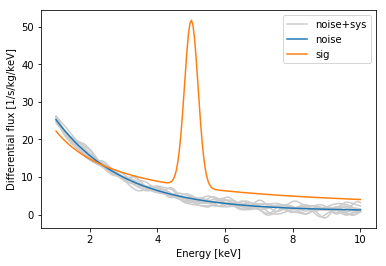

In [24]:
for s in cov_samples:
    plt.plot(x, (noise+s)/dx, '0.8')
plt.plot(x, (s+noise)/dx, '0.8', label="noise+sys")
plt.plot(x, noise/dx, label="noise")
plt.plot(x, sig/dx, label="sig")
plt.legend()
plt.xlabel("Energy [keV]")
plt.ylabel("Differential flux [1/s/kg/keV]")

### Definition exposure and corresponding expected events

In [25]:
# Detector exposure (e.g. in kg s)
exposure = np.ones_like(x)*100.

print "Expected number of total background events: %.2f"%(noise*exposure).sum()
print "Expected number of total signal events (for theta_0=1): %.2f"%(flux[0]*exposure).sum()

Expected number of total background events: 5758.24
Expected number of total signal events (for theta_0=1): 443.62


## The swordfish model

In [26]:
SF = sf.Swordfish(flux, noise, Sigma, exposure, constraints = [None, 0.1, 0.1], verbose=False)

### Fisher information matrix of the model
The Fisher information matrix
$$\mathcal{I}_{ij} \equiv -\left\langle \frac{\partial^2}{\partial\theta_i\partial\theta_j}
\ln\mathcal{L}\right\rangle_\mathcal{D},$$
where the average is taken over data with all $\theta_i=0$ is given by

In [27]:
print SF.fishermatrix()

[[   14.23471408    94.20875707    15.30724583]
 [   94.20875707  1710.78730655   144.01639639]
 [   15.30724583   144.01639639   133.47107331]]


### Standard devitations of model components

The standard deviation of the various components is given by (the variance of components $i$ equals $\mathcal{I}^{-1}_{ii}$)

In [28]:
print "1-sigma uncertainty of sig : %.2f"%SF.variance(0)**0.5
print "1-sigma uncertainty of bkg1: %.2f"%SF.variance(1)**0.5
print "1-sigma uncertainty of bkg2: %.2f"%SF.variance(2)**0.5

1-sigma uncertainty of sig : 0.34
1-sigma uncertainty of bkg1: 0.03
1-sigma uncertainty of bkg2: 0.09


### Signal-to-noise ratio vs effective signal-to-noise ratio (aka effective Fisher information flux)
The effective signal-to-noise ratio is exposure dependent

- Low exposures lead to large statistical errors which dominate the measurement
- High expsoures lead to small statistical errors where systematic errors start to dominate

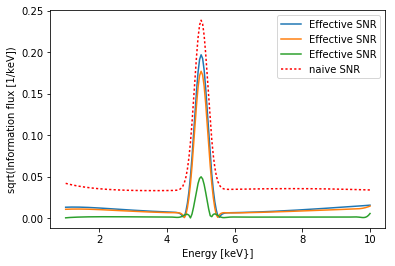

In [29]:
for s in np.logspace(-3, 0, 3):
    SFmod = sf.Swordfish(flux, noise, Sigma, exposure*s, verbose=False)
    f = SFmod.effectiveinfoflux(0)
    plt.plot(x, np.sqrt(f), '-', label="Effective SNR")
plt.plot(x, np.sqrt(flux[0]**2/noise), 'r:', label='naive SNR')
plt.legend()
plt.xlabel("Energy [keV}]")
plt.ylabel("sqrt(Information flux [1/keV])")

## Effective Counts Method

Projected upper limits can be derived using the Effective Counts Method

In [30]:
EC = sf.EffectiveCounts(SF)  # Instantiate effective counts class

### Total vs. effective counts

In [31]:
theta_0 = 0.1
s = EC.counts(0,theta_0)
b = EC.noise_counts()
print "Number of total signal counts: %.2f"%s
print "Number of total bkg counts: %.2f"%b
print

seff, beff = EC.effectivecounts(0, theta_0)
print "Number of effective signal counts: %.2f"%seff
print "Number of effective bkg counts: %.2f"%beff

Number of total signal counts: 44.36
Number of total bkg counts: 5758.24

Number of effective signal counts: 9.03
Number of effective bkg counts: 948.70


The effective signal and background counts depend on the exposure

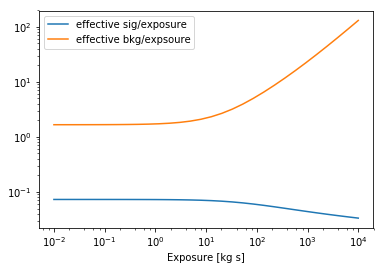

In [32]:
a = []; s = []; b = []
for scale in np.logspace(-4, 2, 30):
    SFmod = sf.Swordfish(flux, noise, Sigma, exposure*scale, verbose=False)
    ECmod = sf.EffectiveCounts(SFmod)
    seff, beff = ECmod.effectivecounts(0, theta_0)
    a.append(scale); s.append(seff); b.append(beff)
a = np.array(a)*exposure[0]; s = np.array(s); b = np.array(b)
plt.loglog(a, s/a, label="effective sig/exposure")
plt.loglog(a, b/a, label="effective bkg/expsoure")
plt.legend()
plt.xlabel("Exposure [kg s]")

### Projected upper limits on the signal component parameter

In [33]:
alpha = 0.05  # Statistical power of constraints (here 95%CL)
theta_0_UL = EC.upperlimit(alpha, 0)
print "Projected upper limit on signal theta_0: %.2f"%theta_0_UL

Projected upper limit on signal theta_0: 0.58


### Statistic, background and systematic-limited regimes of projected upper limits

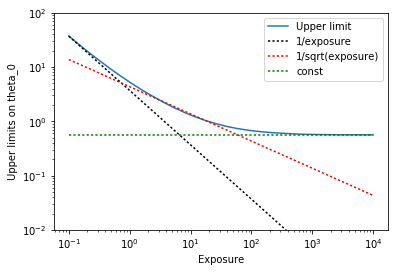

In [34]:
a = []; ul = []
for scale in np.logspace(-3, 2, 30):
    SFmod = sf.Swordfish(flux, noise, Sigma, exposure*scale, verbose=False)
    ECmod = sf.EffectiveCounts(SFmod)
    UL = ECmod.upperlimit(alpha, 0)
    a.append(scale); ul.append(UL)
a = np.array(a); ul = np.array(ul)
plt.loglog(a*exposure[0], ul, label="Upper limit")

plt.loglog(a*exposure[0], ul[0]/(a/a[0]), 'k:', label="1/exposure")
i = 13
plt.loglog(a*exposure[0], ul[i]/(a/a[i])**0.5, 'r:', label='1/sqrt(exposure)')
i = 29
plt.loglog(a*exposure[0], ul[i]/(a/a[i])**0.0, 'g:', label='const')

plt.ylim([1e-2, 1e2])
plt.legend()
plt.xlabel("Exposure")
plt.ylabel("Upper limits on theta_0")

### Detection threshold

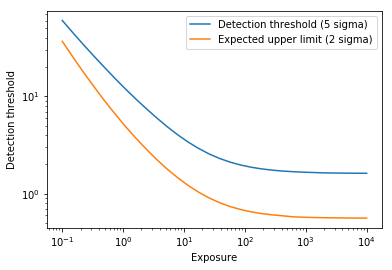

In [35]:
a = []; dt_list = []
for scale in np.logspace(-3, 2, 30):
    SFmod = sf.Swordfish(flux, noise, Sigma, exposure*scale, verbose=False)
    ECmod = sf.EffectiveCounts(SFmod)
    alpha = 1e-6
    dt = ECmod.discoveryreach(alpha, 0, gaussian=False)
    dt_list.append(dt)
    a.append(scale*exposure[0])
plt.loglog(a, dt_list, label='Detection threshold (5 sigma)')
plt.loglog(a, ul, label="Expected upper limit (2 sigma)")
plt.legend()
plt.xlabel("Exposure")
plt.ylabel("Detection threshold")

### Approximate full profile likelihood ratios with Poisson likelihood ratio of effective counts

In [36]:
#thetas = [80., 0., 0.] 
#thetas0 = [0., 0., 0.]
#free_thetas = [False, True, True]
#SFmod = sf.Swordfish(flux, noise, Sigma*.0000, exposure*.01, verbose=False)
#ECmod = sf.EffectiveCounts(SFmod)

thetas = [1.,] 
thetas0 = [0.,]
free_thetas = [False,]
SFmod = sf.Swordfish([flux[0]], noise, Sigma*10., exposure*1., verbose=False)
ECmod = sf.EffectiveCounts(SFmod)

# No signal in data, ln(L(sig)/L(no sig))
lnL1 = SFmod.profile_lnL(thetas, thetas0, free_thetas = free_thetas, epsilon = 1e-5)
lnL2 = SFmod.profile_lnL(thetas0, thetas0, free_thetas = free_thetas)
seff, beff = ECmod.effectivecounts(0, thetas[0])
Delta_lnL = (beff)*np.log((seff+beff)/beff)-seff
print "Exact profile log-likelihood-ratio:", (lnL1 - lnL2)
print "Effective counts method approximation of log-likelihood-ratio:", Delta_lnL
print

# Signal in data, ln(L(sig)/L(no sig))
lnL1 = SFmod.profile_lnL(thetas, thetas, free_thetas = free_thetas)
lnL2 = SFmod.profile_lnL(thetas0, thetas, free_thetas = free_thetas, epsilon = 1e-5)
seff, beff = ECmod.effectivecounts(0, thetas[0])
Delta_lnL = (seff+beff)*np.log((seff+beff)/beff)-seff
print "Exact profile log-likelihood-ratio:", (lnL1 - lnL2)
print "Effective counts method approximation of log-likelihood-ratio:", Delta_lnL

Exact profile log-likelihood-ratio: -0.955299906384
Effective counts method approximation of log-likelihood-ratio: -0.94746590133

Exact profile log-likelihood-ratio: 0.946149338228
Effective counts method approximation of log-likelihood-ratio: 0.95098778443
